# Suavización exponencial Primer Orden (SES)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [2]:
djia_df = pd.read_excel('../Datasets/DJIA_Jan2016_Dec2016.xlsx')

In [3]:
djia_df['Date'] = pd.to_datetime(djia_df['Date'], '%Y-%m-%d')
djia_df.index = djia_df['Date']
djia_df.drop('Date', axis=1, inplace=True)
djia_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [4]:
djia_ts = pd.Series(data=djia_df['Close'].values, index=djia_df.index)

In [5]:
djia_ts.head()

Date
2016-01-04    17148.939453
2016-01-05    17158.660156
2016-01-06    16906.509766
2016-01-07    16514.099609
2016-01-08    16346.450195
dtype: float64

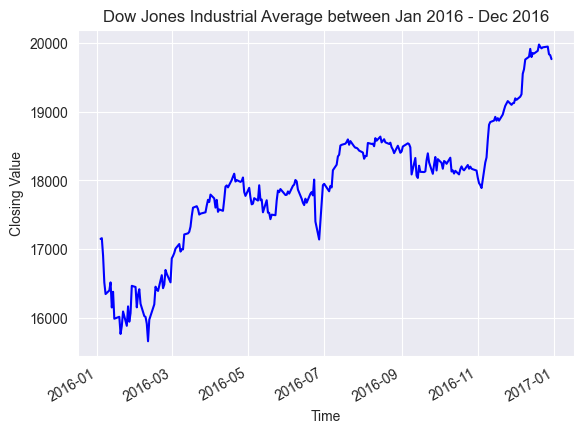

In [6]:
plt.figure()
djia_ts.plot(color='b')
plt.title('Dow Jones Industrial Average between Jan 2016 - Dec 2016')
plt.xlabel('Time')
plt.ylabel('Closing Value')
plt.show()

In [7]:
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

In [8]:
dji_smooth1 = firstsmooth(y=djia_ts, lambda_=0.4)

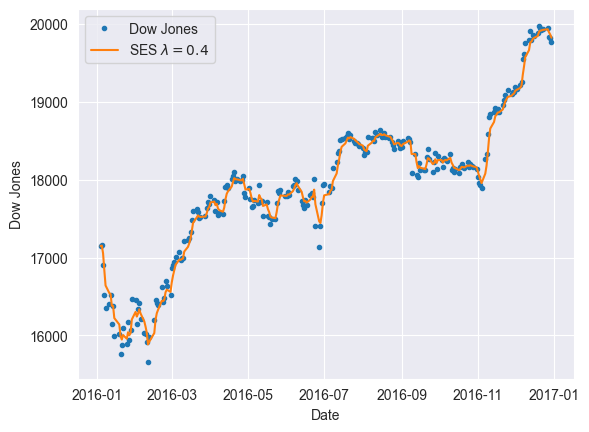

In [9]:
plt.plot(djia_ts, marker='o', linestyle='', markersize=3, label='Dow Jones')
plt.plot(dji_smooth1, label='SES $\lambda=0.4$')
plt.xlabel('Date')
plt.ylabel('Dow Jones')
plt.legend()
plt.show()

# Implementación manual

In [12]:
def measacc_fs(y, lambda_):
    out = firstsmooth(y, lambda_)
    T = len(y)
    yh = y.copy().values
    out = pd.concat([pd.Series([y[0]]), out.iloc[:-1]], ignore_index=True).values
    prederr = yh - out
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / yh)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

In [13]:
measacc_fs(djia_ts, 0.4)

,SSE,MAPE,MAD,MSD
0,6.844383e+06,0.689939,121.602389,27160.251204


# Implementación con libreria

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [15]:
def measacc_hw(y, lambda_):
    model = ExponentialSmoothing(y.values)
    fit = model.fit(smoothing_level=lambda_)
    T = len(y)
    yh = y.copy().values
    y_pred = pd.Series(data=fit.fittedvalues, index=y.index)
    out = pd.concat([pd.Series([y[0]]), y_pred[:-1]], ignore_index=True).values
    prederr = yh - out
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / yh)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

In [16]:
measacc_hw(djia_ts, 0.4)

,SSE,MAPE,MAD,MSD
0,1.084430e+07,0.876061,154.763863,43032.952285


# Suavización exponencial de Segundo Orden

In [17]:
import matplotlib.pyplot as plt

In [19]:
cpi_smooth1 = firstsmooth(y=djia_ts, lambda_=0.3)
cpi_smooth2 = firstsmooth(y=cpi_smooth1, lambda_=0.3)

In [20]:
cpi_hat = 2 * cpi_smooth1 - cpi_smooth2

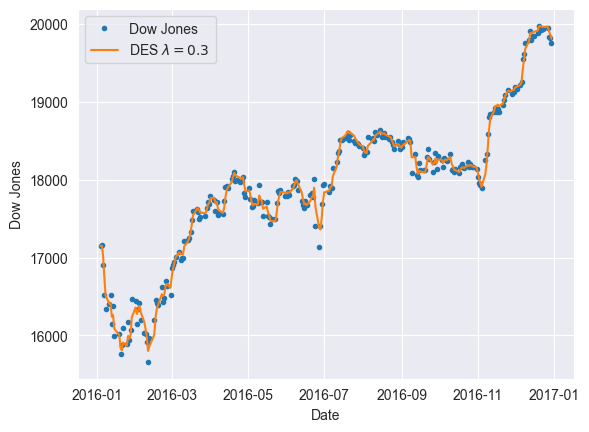

In [21]:
plt.plot(djia_ts, marker='o', linestyle='', markersize=3, label='Dow Jones')
plt.plot(cpi_hat, label='DES $\lambda=0.3$')
plt.xlabel('Date')
plt.ylabel('Dow Jones')
plt.legend()
plt.show()

# Forecasting

In [22]:
import pandas as pd

In [23]:
speed_df = pd.read_csv("https://raw.githubusercontent.com/lihkir/Data/main/weekly_average_speed.csv")
speed_df.head()

,week,speed
0,1,47.12
1,2,45.01
2,3,44.69
3,4,45.41
4,5,45.45


In [24]:
speed_ts = pd.Series(data=speed_df['speed'].values, index=speed_df.index)

In [25]:
speed_ts.head()

0    47.12
1    45.01
2    44.69
3    45.41
4    45.45
dtype: float64

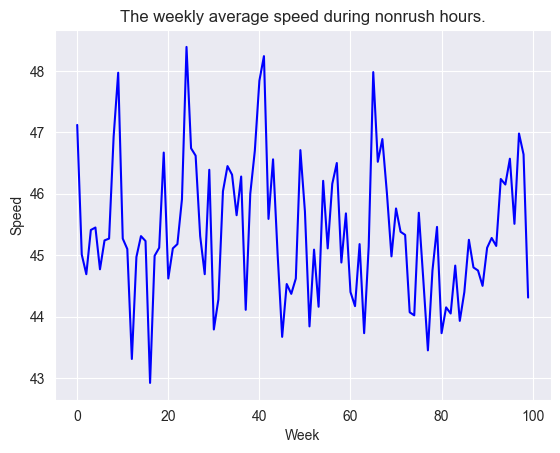

In [26]:
plt.figure()
speed_ts.plot(color='b')
plt.title('The weekly average speed during nonrush hours.')
plt.xlabel('Week')
plt.ylabel('Speed');

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
lambda_vec = np.arange(0.1, 1.0, 0.1)

In [30]:
def sse_speed(sc):
    return measacc_fs(speed_ts, sc)['SSE'].values[0]

In [31]:
sse_vec = pd.Series()
for lambda_ in lambda_vec:
    sse_vec.loc[len(sse_vec)] = sse_speed(lambda_)

In [32]:
opt_lambda = sse_vec.min()

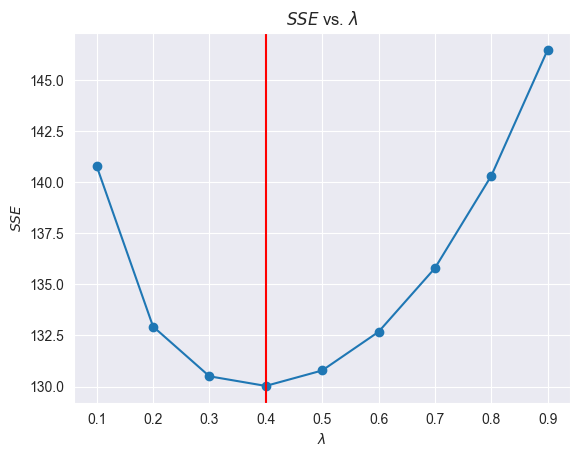

In [35]:
plt.plot(lambda_vec, sse_vec, marker='o', linestyle='-')
plt.title("$SSE$ vs. $\lambda$")
plt.xlabel('$\lambda$')
plt.ylabel('$SSE$')
plt.axvline(x=lambda_vec[sse_vec.idxmin()], color='red')
plt.show()

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
cpi_data = pd.read_csv("https://raw.githubusercontent.com/lihkir/Data/main/CPI.csv", skiprows=1, skipfooter=1, engine='python')

In [38]:
cpi_data.head()

,Year,Period,Consumer Price Index,Over-the-Year Percent Change,Over-the-Month Percent Change
0,2024,March,312.3,3.5%,0.6%
1,2024,February,310.3,3.2%,0.6%
2,2024,January,308.4,3.1%,0.5%
3,2023,December,306.7,3.4%,-0.1%
4,2023,November,307.1,3.1%,-0.2%


In [39]:
cpi_data['Date'] = cpi_data['Period'].astype(str) + '-' + cpi_data['Year'].astype(str)

In [40]:
cpi_data.index = cpi_data['Date']
cpi_data.drop('Date', axis=1, inplace=True)
cpi_data.head()

,Year,Period,Consumer Price Index,Over-the-Year Percent Change,Over-the-Month Percent Change
Date,,,,,
March-2024,2024,March,312.3,3.5%,0.6%
February-2024,2024,February,310.3,3.2%,0.6%
January-2024,2024,January,308.4,3.1%,0.5%
December-2023,2023,December,306.7,3.4%,-0.1%
November-2023,2023,November,307.1,3.1%,-0.2%


In [41]:
cpi_ts = pd.Series(data=cpi_data['Consumer Price Index'].values, index=cpi_data.index)[::-1]

In [42]:
cpi_ts

Date
January-1913       9.8
February-1913      9.8
March-1913         9.8
April-1913         9.8
May-1913           9.7
                 ...  
November-2023    307.1
December-2023    306.7
January-2024     308.4
February-2024    310.3
March-2024       312.3
Length: 1335, dtype: float64

In [43]:
cpi_dates = cpi_ts[cpi_ts.index.get_loc('January-1995'):cpi_ts.index.get_loc('December-2004')+1]

In [44]:
cpi_dates

Date
January-1995      150.3
February-1995     150.9
March-1995        151.4
April-1995        151.9
May-1995          152.2
                  ...  
August-2004       189.5
September-2004    189.9
October-2004      190.9
November-2004     191.0
December-2004     190.3
Length: 120, dtype: float64

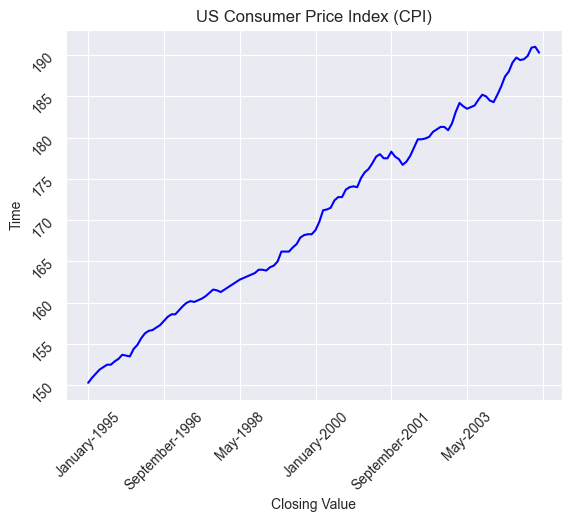

In [45]:
fig, ax = plt.subplots()

cpi_dates.plot(ax=ax, color='b')
ax.set_title('US Consumer Price Index (CPI)')
ax.set_xlabel('Closing Value')
ax.set_ylabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)

plt.show()

In [46]:
lambda_ = 0.3
tau_length = 12

In [47]:
cpi_smooth1 = firstsmooth(cpi_dates.iloc[:-tau_length], lambda_)
cpi_smooth2 = firstsmooth(cpi_smooth1, lambda_)

In [48]:
cpi_hat = 2 * cpi_smooth1 - cpi_smooth2

In [49]:
tau = np.arange(1, tau_length+1)

In [51]:
T = len(cpi_smooth1)

In [52]:
cpi_forecast = (2 + tau * (lambda_ / (1 - lambda_))) * cpi_smooth1[T-1] - (1 + tau * (lambda_ / (1 - lambda_))) * cpi_smooth2[T-1]

In [53]:
ctau = np.sqrt(1 + (lambda_ / ((2 - lambda_)**3)) * (10 - 14 * lambda_ + 5 * (lambda_**2) + 2 * tau * lambda_ * (4 - 3 * lambda_) + 2 * (tau**2) * (lambda_**2)))

In [54]:
alpha_lev = 0.05

In [55]:
sig_est = np.sqrt(np.var(cpi_dates.iloc[1:] - cpi_hat[:-1]))

In [56]:
cl = np.quantile(ctau / ctau[0] * sig_est, 1 - alpha_lev / 2)

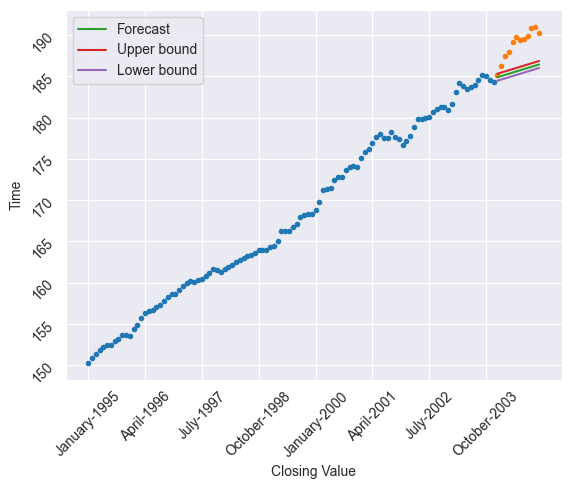

In [57]:
fig, ax = plt.subplots()
ax.plot(cpi_dates.index[:-tau_length], cpi_dates.iloc[:-tau_length].values, marker='o', linestyle='', markersize=3)
ax.plot(cpi_dates.index[-tau_length:], cpi_dates.iloc[-tau_length:].values, marker='o', linestyle='', markersize=3)
ax.plot(cpi_dates.index[-tau_length:], cpi_forecast, label='Forecast')
ax.plot(cpi_dates.index[-tau_length:], cpi_forecast + cl, label='Upper bound')
ax.plot(cpi_dates.index[-tau_length:], cpi_forecast - cl, label='Lower bound')
n = 15
plt.xticks(range(0, len(cpi_dates.index), n), rotation=45)
ax.set_xlabel('Closing Value')
ax.set_ylabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)
plt.legend()
plt.show()

In [58]:
import numpy as np
from scipy.stats import norm

In [59]:
lambda_ = 0.3
T = 108
tau = 12
alpha_lev = 0.05
cpi_forecast = np.zeros(tau)
cl = np.zeros(tau)
cpi_smooth1 = np.zeros(T + tau)
cpi_smooth2 = np.zeros(T + tau)

In [61]:
for i in range(1, tau + 1):
    cpi_smooth1[:T + i - 1] = firstsmooth(y=cpi_dates.iloc[:T + i - 1], lambda_=lambda_)
    cpi_smooth2[:T + i - 1] = firstsmooth(y=cpi_smooth1[:T + i - 1], lambda_=lambda_)
    cpi_forecast[i - 1] = (2 + (lambda_ / (1 - lambda_))) * cpi_smooth1[T + i - 2] - \
                          (1 + (lambda_ / (1 - lambda_))) * cpi_smooth2[T + i - 2] # horizon one each time
    cpi_hat = 2 * cpi_smooth1[:T + i - 1] - cpi_smooth2[:T + i - 1]
    sig_est = np.sqrt(np.var(cpi_dates.iloc[1:T + i - 1] - cpi_hat[:-1]))
    cl[i - 1] = norm.ppf(1 - alpha_lev / 2) * sig_est

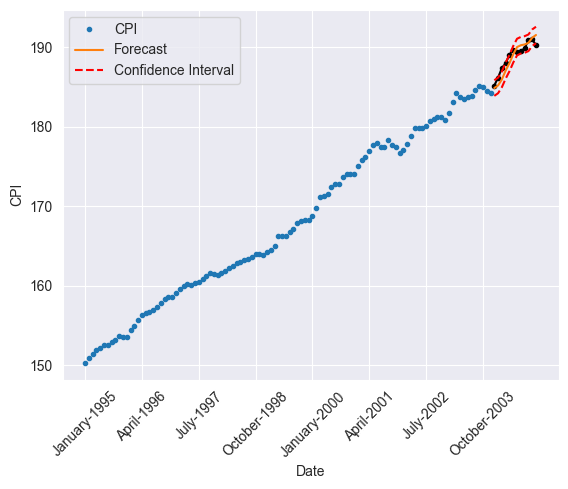

In [62]:
plt.figure()
plt.plot(cpi_dates.index[:-tau], cpi_dates.iloc[:-tau].values, marker='o', linestyle='', markersize=3, label='CPI')
plt.plot(cpi_dates.index[-tau:], cpi_dates.iloc[-tau:].values, marker='o', markersize=3, color='black')
plt.plot(cpi_dates.index[-tau:], cpi_forecast, label='Forecast')
plt.plot(cpi_dates.index[-tau:], cpi_forecast + cl, linestyle='--', color='red', label='Confidence Interval')
plt.plot(cpi_dates.index[-tau:], cpi_forecast - cl, linestyle='--', color='red')
plt.legend()
n = 15
plt.xticks(range(0, len(cpi_dates.index), n), rotation=45)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

# Suavización con factor de descuento

In [64]:
def tlsmooth(y, delta_, y_tilde_start=None, lambda_start=1):
    T = len(y)
    
    Qt = np.zeros(T)
    Dt = np.zeros(T)
    y_tilde = np.zeros(T)
    lambd = np.zeros(T)
    err = np.zeros(T)
    
    lambd[0] = lambda_start
    if y_tilde_start is None:
        y_tilde[0] = y[0]
    else:
        y_tilde[0] = y_tilde_start
    
    for i in range(1, T):
        err[i] = y[i] - y_tilde[i-1]
        Qt[i] = delta_ * err[i] + (1 - delta_) * Qt[i-1]
        Dt[i] = delta_ * abs(err[i]) + (1 - delta_) * Dt[i-1]
        lambd[i] = abs(Qt[i] / Dt[i])
        y_tilde[i] = lambd[i] * y[i] + (1 - lambd[i]) * y_tilde[i-1]
    
    return np.column_stack((y_tilde, lambd, err, Qt, Dt))

In [65]:
out_tl_dji = tlsmooth(djia_ts, 0.3)

In [66]:
last_fc = 100

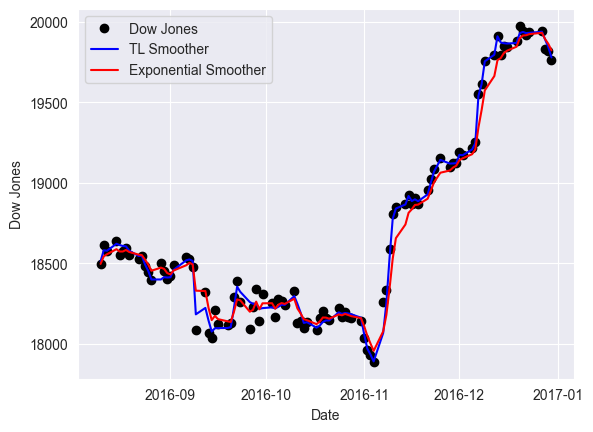

In [75]:
plt.plot(djia_ts.index[-last_fc:], djia_ts[-last_fc:], marker='o', linestyle='', color='black', label='Dow Jones')
plt.plot(djia_ts.index[-last_fc:], out_tl_dji[-last_fc:, 0], color='blue', label='TL Smoother')
plt.plot(djia_ts.index[-last_fc:], dji_smooth1[-last_fc:], color='red', label='Exponential Smoother')
plt.xlabel('Date')
plt.ylabel('Dow Jones')
plt.legend()
plt.show()

# Holt Winters

In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

In [77]:
data = sm.datasets.co2.load_pandas()
y = data.data
y.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [78]:
y = y['co2'].resample('MS').mean()
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [79]:
y.isnull().sum()

5

In [80]:
y = y.fillna(y.bfill())
y.isnull().sum()

0

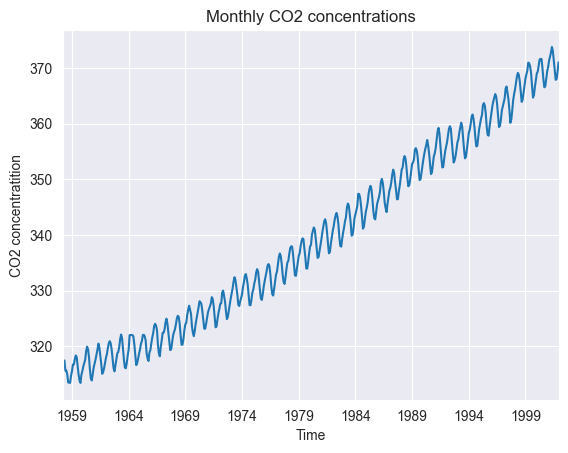

In [81]:
y.plot()
plt.title('Monthly CO2 concentrations')
plt.xlabel('Time')
plt.ylabel('CO2 concentratition');
plt.show()

In [82]:
tau_test = 48
tau_val  = 48    

train = y[:-(tau_val + tau_test)].copy()
val   = y[-(tau_val + tau_test):-tau_test].copy()
test  = y[-tau_test:].copy()

print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

Train: 430, Validation: 48, Test: 48


In [83]:
def plot_model(train, val, test, y_pred, title):
    plt.figure(figsize=(10, 6))

    train[-300:].plot(legend=True, label="Train", color='blue', title=f"{title} - Train, Validation, Test and Prediction")
    val.plot(legend=True, label="Validation", color='orange')
    test.plot(legend=True, label="Test", color='green')
    y_pred.plot(legend=True, label="Prediction", color='red', style='--')

    mae = mean_absolute_error(test, y_pred)
    plt.title(f"{title}, MAE: {round(mae, 2)}")

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

In [84]:
def ses_optimizer(train, val, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

In [85]:
def ses_model_tuning(train, val, test, step, title="Model Tuning - Single Exponential Smoothing"):
    
    alphas = np.arange(0.8, 1, 0.01)
    best_alpha, best_mae = ses_optimizer(train, val, alphas, step=step)
    
    train_val = pd.concat([train, val])
    final_model = SimpleExpSmoothing(train_val).fit(smoothing_level=best_alpha, optimized=False)
    
    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    
    plot_model(train, val, test, y_pred, title)

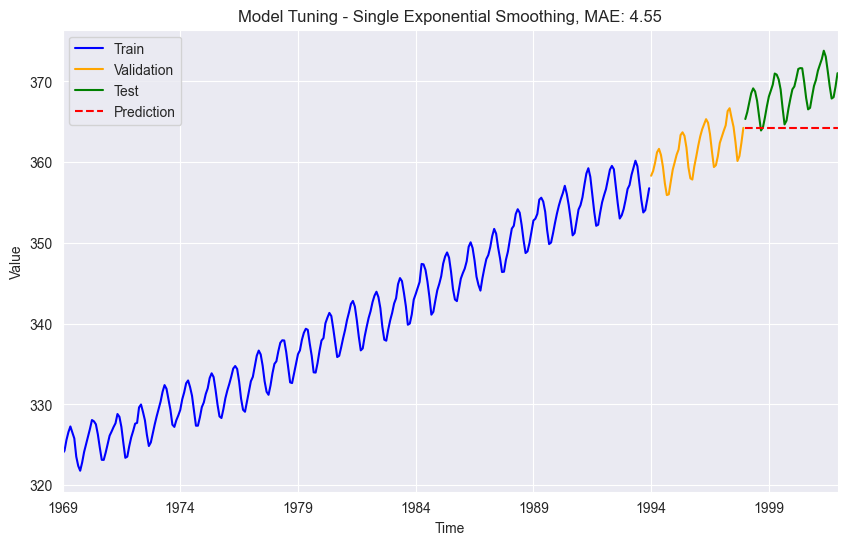

In [86]:
ses_model_tuning(train, val, test, step=tau_test)

In [87]:
def des_optimizer(train, val, alphas, betas, trend, step):

    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae

    return best_alpha, best_beta, best_mae

In [88]:
def des_model_tuning(train , val, test, step, trend, title="Model Tuning - Double Exponential Smoothing"):
    
    alphas = np.arange(0.01, 1, 0.10)
    betas  = np.arange(0.01, 1, 0.10)
    best_alpha, best_beta, best_mae = des_optimizer(train, val, alphas, betas, trend=trend, step=step)

    train_val = pd.concat([train, val])
    final_model = ExponentialSmoothing(train_val, trend=trend).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    
    plot_model(train, val, test, y_pred, title)

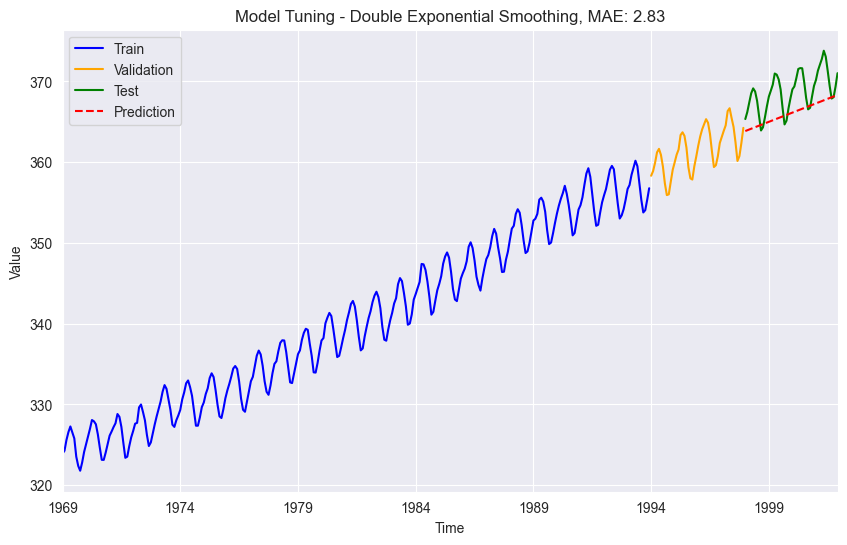

In [89]:
des_model_tuning(train, val, test, step=tau_test, trend='add')

In [90]:
def tes_optimizer(train, val, abg, trend, seasonal,  seasonal_periods, step):
    
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

In [91]:
def tes_model_tuning(train, val, test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
    
    alphas = betas = gammas = np.arange(0.10, 1, 0.10)
    abg = list(itertools.product(alphas, betas, gammas))
    best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, val, abg=abg, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, step=step)
    
    final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    y_pred = final_model.forecast(step + step)[-step:]
    mae = mean_absolute_error(test, y_pred)
    
    plot_model(train, val, test, y_pred, title)
    
    return best_alpha, best_beta, best_gamma, best_mae

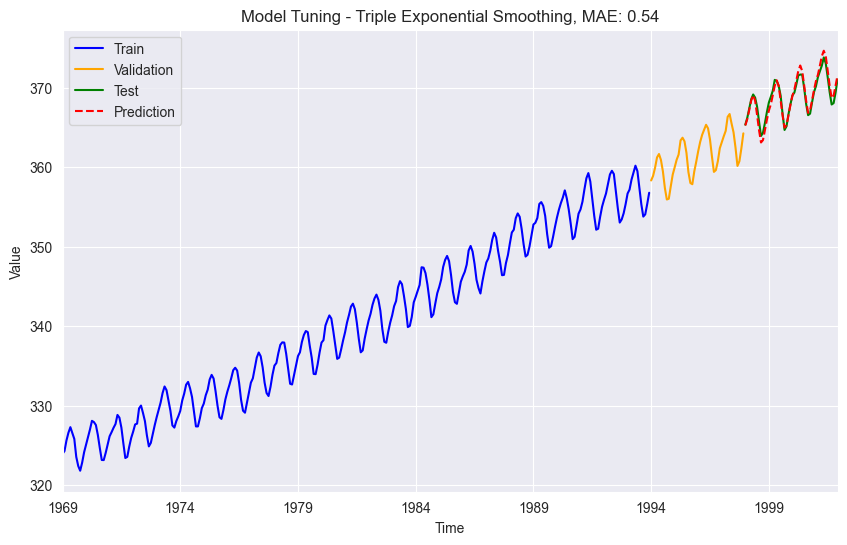

In [92]:
best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, val, test, step=tau_test, trend='add', seasonal='add', seasonal_periods=12)